In [1]:
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from numpy.random import poisson, beta, uniform

import occSimFuncs as occFunc
from tvguide import TessPointing

from astropy.coordinates import SkyCoord
from astropy import units as u

%matplotlib inline

In [2]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.

consts = {'sigma_threshold': 7.3}

def get_insol(teff, ars):
    p1 = (teff/5771)**4
    p2 = (215.1 / ars)**2
    return p1 * p2

In [3]:
fn = '../data/fiducial.csv.bz2'

newDF = pd.read_csv(fn)

In [4]:
newDF['nsectors'] = np.round(newDF.obs_len/27.4)

In [5]:
newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits
total_planets = newDF.detected.sum()
print(total_planets)
detected_DF = newDF[newDF.detected == True]

brightstar_DF = detected_DF[detected_DF.TESSMAG < 11.]
coolstar_DF = detected_DF[detected_DF.TEFF < 3900]
verycool_df = detected_DF[detected_DF.TEFF < 3410]

920


In [6]:
q = [print('{}: {} & {} & {}'.format(x,*np.percentile(detected_DF.loc[:,x], [50,5,95], axis=0))) for x in detected_DF.columns]

Unnamed: 0: 127061.0 & 14241.949999999999 & 292934.3
Unnamed: 0.1: 4506032.0 & 481249.0 & 10109499.35
RA: 198.46166449999998 & 24.27782105 & 339.71100595
DEC: 5.6802814999999995 & -74.42965699999998 & 74.66597665
ECLONG: 174.0080405 & 17.11732995 & 339.93383509999995
ECLAT: 10.850586499999999 & -81.09881594999999 & 81.54982774999996
Ks: 9.421 & 6.752599805 & 11.551549999999999
TESSMAG: 11.036000000000001 & 7.734450094999999 & 14.126249999999999
TEFF: 4124.5 & 3120.8 & 6496.2
RADIUS: 0.6574665049999999 & 0.2208499995 & 1.476916505
MASS: 0.665853175 & 0.19579999050000002 & 1.3434385349999998
CONTRATIO: 0.011017332500000001 & 4.7589651100000014e-05 & 0.36673609849999994
PRIORITY: 0.0705013835 & 0.04801946185 & 0.20760813949999998
SELECTED: 1.0 & 1.0 & 1.0
tess_ccd: 2.0 & 1.0 & 4.0
obs_len: 54.8 & 27.4 & 356.2
isMdwarf: 0.0 & 0.0 & 1.0
isGiant: 1.0 & 1.0 & 1.0
cosi: 0.02180012227831718 & 0.001663219112659753 & 0.08760939212474324
noise_level: 348.0947299277502 & 85.45560968568488 & 2862.87

In [7]:
print('duration (hours): {} & {} & {}'.format(
    *(np.percentile(detected_DF.loc[:,'duration'], [50,5,95], axis=0) * 24)))

duration (hours): 2.0446570461108493 & 0.8028532249188012 & 5.0740137009833814


In [8]:
print('SNR: {} & {} & {}'.format(
    *np.percentile(detected_DF.needed_for_detection * 7.3 / detected_DF.noise_level, [50,5,95])))

SNR: 13.902094748564004 & 7.668006597547557 & 102.93022999748356


1: 46.0%
2: 22.8%
3: 5.4%
4: 2.1%
5: 1.4%
6: 1.1%
7: 1.5%
8: 0.4%
9: 0.5%
10: 1.0%
11: 0.5%
12: 9.1%
13: 8.0%


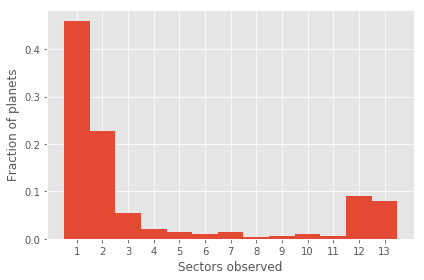

In [9]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1)
    h1 = ax.hist(detected_DF.nsectors, bins=np.arange(0.5,14.5,1), cumulative=False, normed=True)
    ax.set_xlabel('Sectors observed')
    ax.set_ylabel('Fraction of planets')
    ax.xaxis.set_ticks(range(1,14,1))
#     ax.xaxis.set_ticklabels(range(1,14,1))
    fig.tight_layout()
    fig.savefig('../plots/obs_len.png', dpi=200)

q = [print('{:.0f}: {:.1f}%'.format(np.round(h1[1][:-1]+0.5)[i],100*h1[0][i])) for i in range(13)]

In [25]:
print('stars brigter than T=9 is {}'.format(
    detected_DF.TESSMAG[(detected_DF.RADIUS>=0.8) * (detected_DF.TESSMAG<=9)].shape[0]))

stars brigter than T=9 is 110


/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


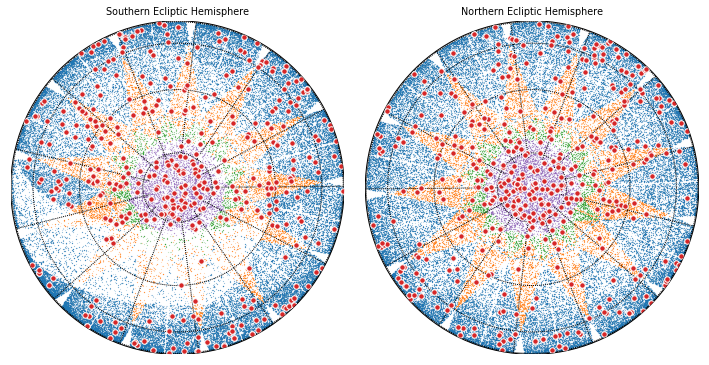

In [88]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('seaborn-paper'):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=[10,5])
    m = Basemap(projection='ortho',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax2)
    m.scatter(newDF.ECLONG.values[newDF.nsectors == 1], newDF.ECLAT.values[newDF.nsectors == 1], 
              s=1.0, alpha=0.2, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.nsectors == 2], newDF.ECLAT.values[newDF.nsectors == 2], 
              s=1.0, alpha=0.2, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.nsectors ==3], newDF.ECLAT.values[newDF.nsectors ==3], 
              s=1.0, alpha=0.2, latlon=True)

    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=30, lw=1, edgecolor='w',
              alpha=1, latlon=True, zorder=100)
    m.scatter(newDF.ECLONG.values[newDF.nsectors >3], newDF.ECLAT.values[newDF.nsectors >3], 
              s=1.0, alpha=0.2, latlon=True)
    
    
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax1)
    m.scatter(newDF.ECLONG.values[newDF.nsectors == 1], newDF.ECLAT.values[newDF.nsectors == 1], 
              s=1.0, alpha=0.2, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.nsectors == 2], newDF.ECLAT.values[newDF.nsectors == 2], 
              s=1.0, alpha=0.2, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.nsectors ==3], newDF.ECLAT.values[newDF.nsectors ==3], 
              s=1.0, alpha=0.2, latlon=True)

    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
              s=30, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF.ECLONG.values[newDF.nsectors >3], newDF.ECLAT.values[newDF.nsectors >3], 
              s=1.0, alpha=0.2, latlon=True)
    
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)
    ax2.set_title('Northern Ecliptic Hemisphere')
    ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()
    fig.savefig('../plots/skyplot.png', dpi=200)

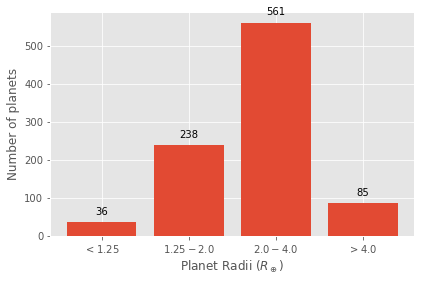

In [138]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 15+height,
                '%d' % int(height),
                ha='center', va='bottom')

counts = np.histogram(detected_DF.planetRadius, bins = [0,1.25,2,4,25])
tl = ['$<1.25$', '$1.25 - 2.0$', '$2.0 - 4.0$', '$>4.0$']
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,)
    
    h1 = ax.bar(np.arange(4), counts[0], tick_label = tl, )
    ax.set_xlabel('Planet Radii ($ R_\oplus$)')
    ax.set_ylabel('Number of planets')
#     ax.set_xlim(0,6)
    fig.tight_layout()
#     fig.savefig('../plots/obs_len.png', dpi=200)
    autolabel(h1)
    fig.savefig('../plots/planet_sizes.png', dpi=200)


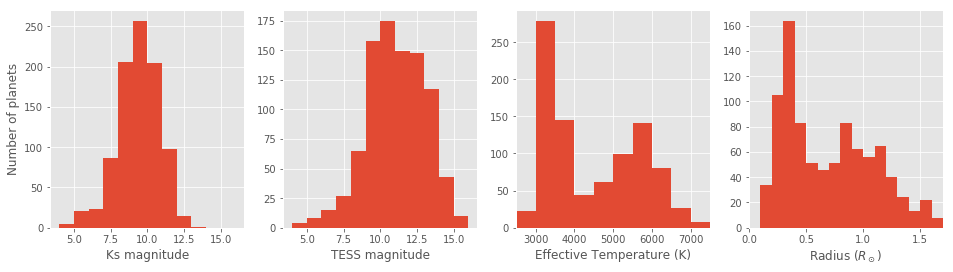

In [185]:
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=[16,4])
    
    h1 = ax1.hist(detected_DF.Ks, bins=np.arange(4,16.5,1))
    ax1.set_xlabel('Ks magnitude')
    ax1.set_ylabel('Number of planets')
    ax4.set_xlim(4,16.0)
    
    h2 = ax2.hist(detected_DF.TESSMAG, bins=np.arange(4,16.5,1))
    ax2.set_xlabel('TESS magnitude')
    ax4.set_xlim(4,16.0)
    
    h3 = ax3.hist(detected_DF.TEFF, bins=np.arange(2500,7500+250,500))
    ax3.set_xlabel('Effective Temperature (K)')
    ax3.set_xlim(2500,7500)
    
    h4 = ax4.hist(detected_DF.RADIUS, bins=np.arange(0,1.8,0.1))
    ax4.set_xlabel('Radius ($R_\odot$)')
    ax4.set_xlim(0,1.7)
    
    fig.savefig('../plots/host_stars.png', dpi=200)

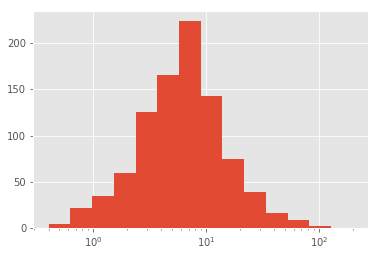

In [321]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,)
    ax.set_xscale('log')
    ax.hist(detected_DF.planetPeriod, bins=np.logspace(np.log10(0.4),np.log10(200),15))

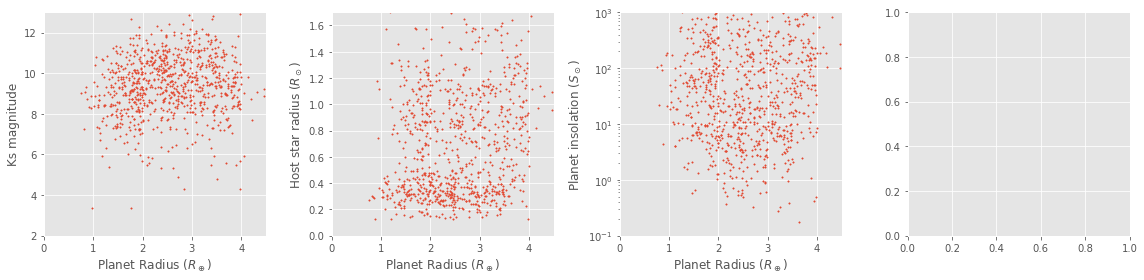

In [219]:
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=[16,4])
    ax1.scatter(detected_DF.planetRadius, detected_DF.Ks, s=2)
    ax1.set_xlim(0,4.5)
    ax1.set_ylim(2,13)
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    ax1.set_ylabel('Ks magnitude')
    
    ax2.scatter(detected_DF.planetRadius, detected_DF.RADIUS, s=2)
    ax2.set_xlim(0,4.5)
    ax2.set_ylim(0,1.7)
    ax2.set_xlabel('Planet Radius ($R_\oplus$)')
    ax2.set_ylabel('Host star radius ($R_\odot$)')
    
    ax3.scatter(detected_DF.planetRadius, get_insol(detected_DF.TEFF, detected_DF.ars), s=2)
    ax3.set_xlim(0,4.5)
    ax3.set_ylim(0.1,1000)
    ax3.set_yscale("log",)
    ax3.set_xlabel('Planet Radius ($R_\oplus$)')
    ax3.set_ylabel('Planet insolation ($S_\odot$)')
    
    fig.tight_layout()

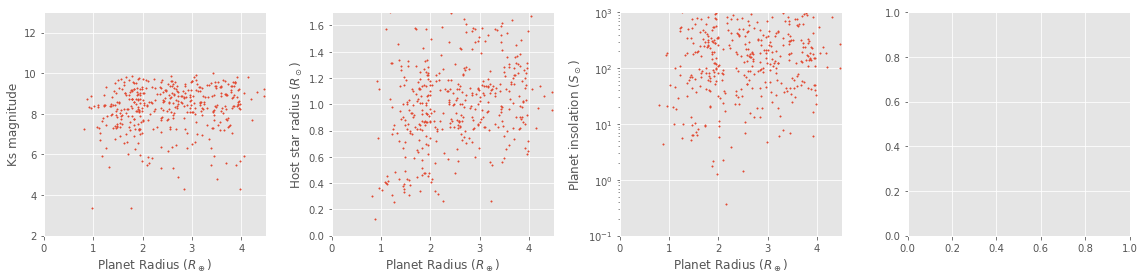

In [220]:
#bright stars
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=[16,4])
    ax1.scatter(brightstar_DF.planetRadius, brightstar_DF.Ks, s=2)
    ax1.set_xlim(0,4.5)
    ax1.set_ylim(2,13)
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    ax1.set_ylabel('Ks magnitude')
    
    ax2.scatter(brightstar_DF.planetRadius, brightstar_DF.RADIUS, s=2)
    ax2.set_xlim(0,4.5)
    ax2.set_ylim(0,1.7)
    ax2.set_xlabel('Planet Radius ($R_\oplus$)')
    ax2.set_ylabel('Host star radius ($R_\odot$)')
    
    ax3.scatter(brightstar_DF.planetRadius, get_insol(brightstar_DF.TEFF, brightstar_DF.ars), s=2)
    ax3.set_xlim(0,4.5)
    ax3.set_ylim(0.1,1000)
    ax3.set_yscale("log",)
    ax3.set_xlabel('Planet Radius ($R_\oplus$)')
    ax3.set_ylabel('Planet insolation ($S_\odot$)')
    
    fig.tight_layout()

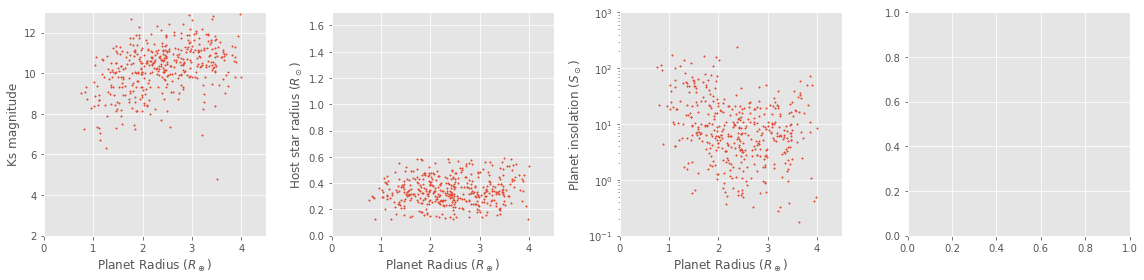

In [221]:
# m dwarfs
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=[16,4])
    ax1.scatter(coolstar_DF.planetRadius, coolstar_DF.Ks, s=2)
    ax1.set_xlim(0,4.5)
    ax1.set_ylim(2,13)
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    ax1.set_ylabel('Ks magnitude')
    
    ax2.scatter(coolstar_DF.planetRadius, coolstar_DF.RADIUS, s=2)
    ax2.set_xlim(0,4.5)
    ax2.set_ylim(0,1.7)
    ax2.set_xlabel('Planet Radius ($R_\oplus$)')
    ax2.set_ylabel('Host star radius ($R_\odot$)')
    
    ax3.scatter(coolstar_DF.planetRadius, get_insol(coolstar_DF.TEFF, coolstar_DF.ars), s=2)
    ax3.set_xlim(0,4.5)
    ax3.set_ylim(0.1,1000)
    ax3.set_yscale("log",)
    ax3.set_xlabel('Planet Radius ($R_\oplus$)')
    ax3.set_ylabel('Planet insolation ($S_\odot$)')
    
    fig.tight_layout()

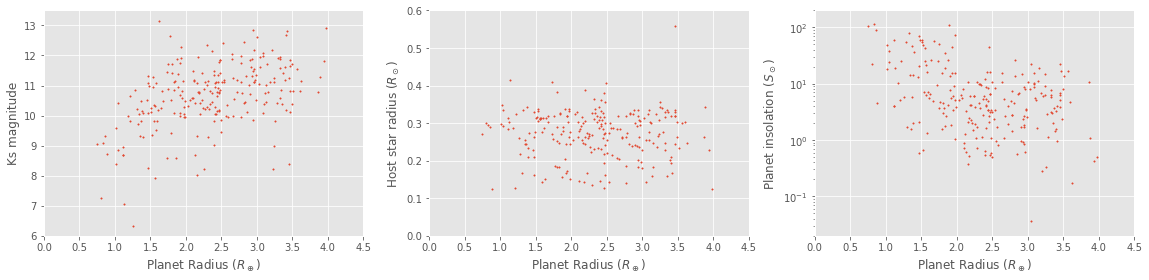

In [245]:
# later than M3
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=[16,4])
    ax1.scatter(verycool_df.planetRadius, verycool_df.Ks, s=2)
    ax1.set_xlim(0,4.5)
    ax1.set_ylim(6,13.5)
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    ax1.set_ylabel('Ks magnitude')
    
    ax2.scatter(verycool_df.planetRadius, verycool_df.RADIUS, s=2)
    ax2.set_xlim(0,4.5)
    ax2.set_ylim(0,0.6)
    ax2.set_xlabel('Planet Radius ($R_\oplus$)')
    ax2.set_ylabel('Host star radius ($R_\odot$)')
    
    ax3.scatter(verycool_df.planetRadius, get_insol(verycool_df.TEFF, verycool_df.ars), s=2)
    ax3.set_xlim(0,4.5)
    ax3.set_ylim(0.02,200)
    ax3.set_yscale("log",)
    ax3.set_xlabel('Planet Radius ($R_\oplus$)')
    ax3.set_ylabel('Planet insolation ($S_\odot$)')
    
    fig.tight_layout()

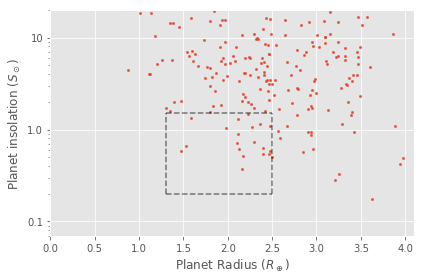

In [296]:
# later than M3
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,figsize=[6,4])

    
    ax.scatter(verycool_df.planetRadius, get_insol(verycool_df.TEFF, verycool_df.ars), s=5)
    ax.set_xlim(0,4.1)
    ax.set_ylim(0.07,20)
    ax.set_yscale("log",)
    ax.set_xlabel('Planet Radius ($R_\oplus$)')
    ax.set_ylabel('Planet insolation ($S_\odot$)')
    ax.yaxis.set_ticklabels(['','','0.1','1.0','10'])
    
    ax.hlines(0.2,1.3,2.5, linestyles='--', alpha=0.5)
    ax.hlines(1.5,1.3,2.5, linestyles='--', alpha=0.5)
    ax.vlines(2.5,0.2,1.5, linestyles='--', alpha=0.5)
    ax.vlines(1.3,0.2,1.5, linestyles='--', alpha=0.5)

    fig.tight_layout()
    fig.savefig('../plots/cool_stars.png', dpi=200)
    
    q = ax.yaxis.get_ticklabels()

In [291]:
np.nonzero((verycool_df.planetRadius >=1.3) & 
 (verycool_df.planetRadius <=2.5) & (get_insol(verycool_df.TEFF, verycool_df.ars) >= 0.2) & 
 (get_insol(verycool_df.TEFF, verycool_df.ars)<1.5))[0].shape

(19,)

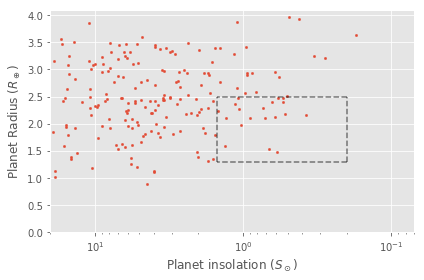

In [300]:
# later than M3
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,figsize=[6,4])

    
    ax.scatter(get_insol(verycool_df.TEFF, verycool_df.ars), verycool_df.planetRadius, s=5)
    ax.set_ylim(0,4.1)
    ax.set_xlim(20,0.07)
    ax.set_xscale("log",)
    ax.set_ylabel('Planet Radius ($R_\oplus$)')
    ax.set_xlabel('Planet insolation ($S_\odot$)')
#     ax.yaxis.set_ticklabels(['','','0.1','1.0','10'])
    
    ax.vlines(0.2,1.3,2.5, linestyles='--', alpha=0.5)
    ax.vlines(1.5,1.3,2.5, linestyles='--', alpha=0.5)
    ax.hlines(2.5,0.2,1.5, linestyles='--', alpha=0.5)
    ax.hlines(1.3,0.2,1.5, linestyles='--', alpha=0.5)

    fig.tight_layout()
#     fig.savefig('../plots/cool_stars.png', dpi=200)
    

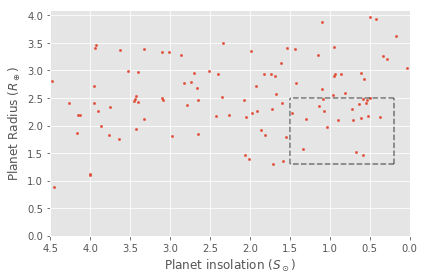

In [304]:
# later than M3
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,figsize=[6,4])

    
    ax.scatter(get_insol(verycool_df.TEFF, verycool_df.ars), verycool_df.planetRadius, s=5)
    ax.set_ylim(0,4.1)
    ax.set_xlim(4.5,0.0)
#     ax.set_xscale("log",)
    ax.set_ylabel('Planet Radius ($R_\oplus$)')
    ax.set_xlabel('Planet insolation ($S_\odot$)')
#     ax.yaxis.set_ticklabels(['','','0.1','1.0','10'])
    
    ax.vlines(0.2,1.3,2.5, linestyles='--', alpha=0.5)
    ax.vlines(1.5,1.3,2.5, linestyles='--', alpha=0.5)
    ax.hlines(2.5,0.2,1.5, linestyles='--', alpha=0.5)
    ax.hlines(1.3,0.2,1.5, linestyles='--', alpha=0.5)

    fig.tight_layout()
#     fig.savefig('../plots/cool_stars.png', dpi=200)
    

In [316]:
np.logspace(np.log10(0.1),np.log10(300),30)

array([  1.00000000e-01,   1.31795546e-01,   1.73700659e-01,
         2.28929731e-01,   3.01719189e-01,   3.97652452e-01,
         5.24088219e-01,   6.90724929e-01,   9.10344690e-01,
         1.19979375e+00,   1.58127472e+00,   2.08404965e+00,
         2.74668462e+00,   3.62000798e+00,   4.77100928e+00,
         6.28797771e+00,   8.28727455e+00,   1.09222587e+01,
         1.43950505e+01,   1.89720354e+01,   2.50042976e+01,
         3.29545504e+01,   4.34326296e+01,   5.72422712e+01,
         7.54427638e+01,   9.94302023e+01,   1.31044578e+02,
         1.72710917e+02,   2.27625295e+02,   3.00000000e+02])